# Four-step Transportation Model

This is an updated of a [blog post](https://davidabailey.com/articles/Creating-a-Four-step-Transportation-Model-in-Python) I wrote three years ago now. I have since created classes to simplify the process of creating a four-step model. The two classes we will use are Zones and OriginDestinationDataFrame.

In [1]:
import matplotlib.pyplot as plt

from dpd.modeling import Zones, OriginDestinationDataFrame

The Zones class defines our analysis zones for the four step model. It is based on a Geopandas GeoDataFrame so it includes a geometry column that maps each zone. The other important columns are Production and Attraction which include the production and attraction data for each zone and the index which is used by the OriginDestinationDataFrame. Zones can be automatically created from US Census data with the from_uscensus method. Otherwise you need to create a GeoDataFrame with the aforementioned columns.

In [2]:
zones = Zones.from_uscensus("35", "2017")

In [3]:
zones.head(1)

,Name,Production,Attraction,state,county,tract,STATEFP,COUNTYFP,TRACTCE,NAME_y,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,,,,,,,,,,
35047957500,"Census Tract 9575, San Miguel County, New Mexico",4117,None,35,047,957500,35,047,957500,9575,Census Tract 9575,G5020,S,9014844373,51188901,+35.5028648,-104.5780441,"POLYGON ((-105.54769 35.78157, -105.54724 35.7..."


One of nice things about this being a GeoDataFrame is that you can easily plot it. In this case we can plot the "Production density" which is really just the population density. We can see each zone (big in rural areas, small in urban areas) and we can see the urban areas have higher densities. This is step one of our four-step model.

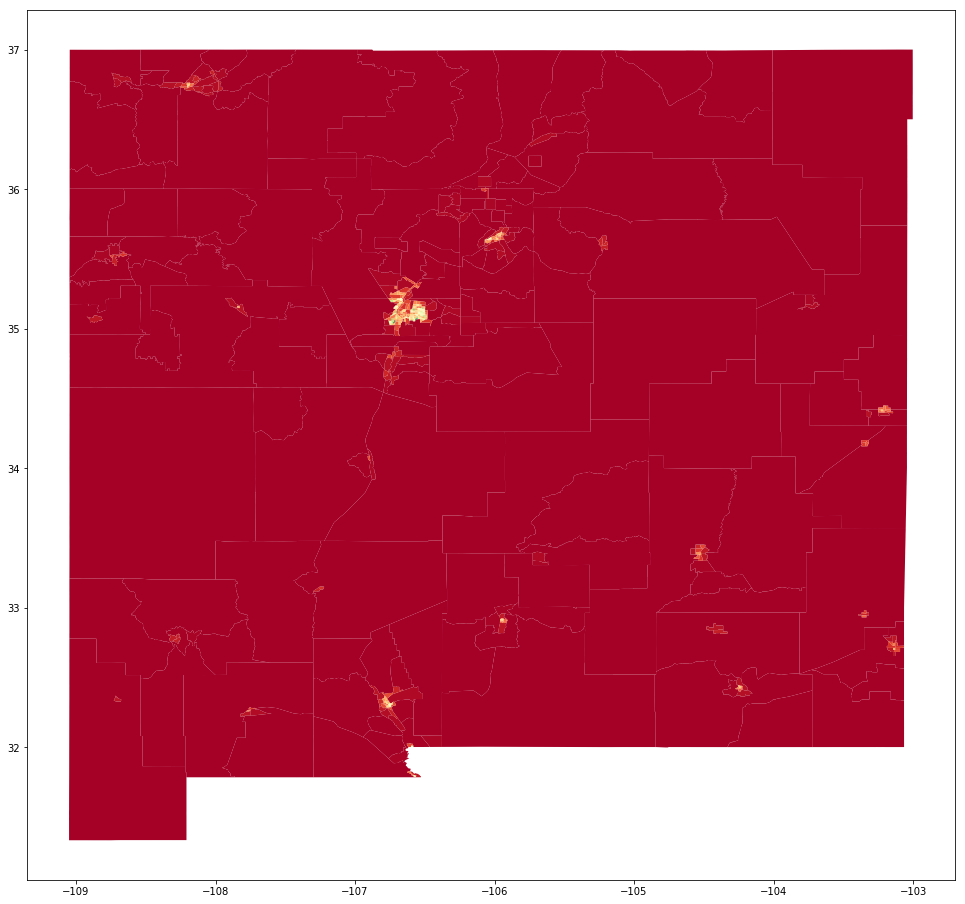

In [4]:
zones["Production density"] = zones["Production"].map(int) / zones["ALAND"]
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
zones.plot(column="Production density", cmap="RdYlGn", ax=ax)

Next we need to create a OriginDestinationDataFrame. We could compute this directly from our Zones object above, but we can also create this by downloading the US Census LODES data using the from_lodes method. This data is already organized as an origin-destination matrix. This is step two of the four-step model.

In [5]:
od = OriginDestinationDataFrame.from_lodes("nm", "2017")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3183: DtypeWarning: Columns (28,29,31,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [6]:
od = OriginDestinationDataFrame(od["S000"].unstack().fillna(0))

In [7]:
od.head(1)

trct_h,35001000107,35001000108,35001000109,35001000110,35001000111,35001000112,35001000113,35001000114,35001000115,35001000116,...,35061970404,35061970405,35061970700,35061970800,35061970901,35061970902,35061971000,35061971100,35061971300,35061971400
trct_w,,,,,,,,,,,,,,,,,,,,,
35001000107,22.0,3.0,1.0,0.0,1.0,5.0,2.0,2.0,1.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are going to skip step three for now. That step will probably get its own notebook. In step four, we assign traffic to our transportation network. For this we need to create a network. We start by building a simple network based on our zones by reducing each zone to it's centroid. We then connect the neighboring centroids.

In [8]:
zones.build_graph()

/usr/local/lib/python3.7/site-packages/geopandas/geodataframe.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


We can then assign our OriginDestinationDataFrame traffic to our Zones transportation network.

In [9]:
od.route_assignment(zones)

And we can plot the final result. This looks about right at first glance. Please take a look at the underlying methods to see what is going on.

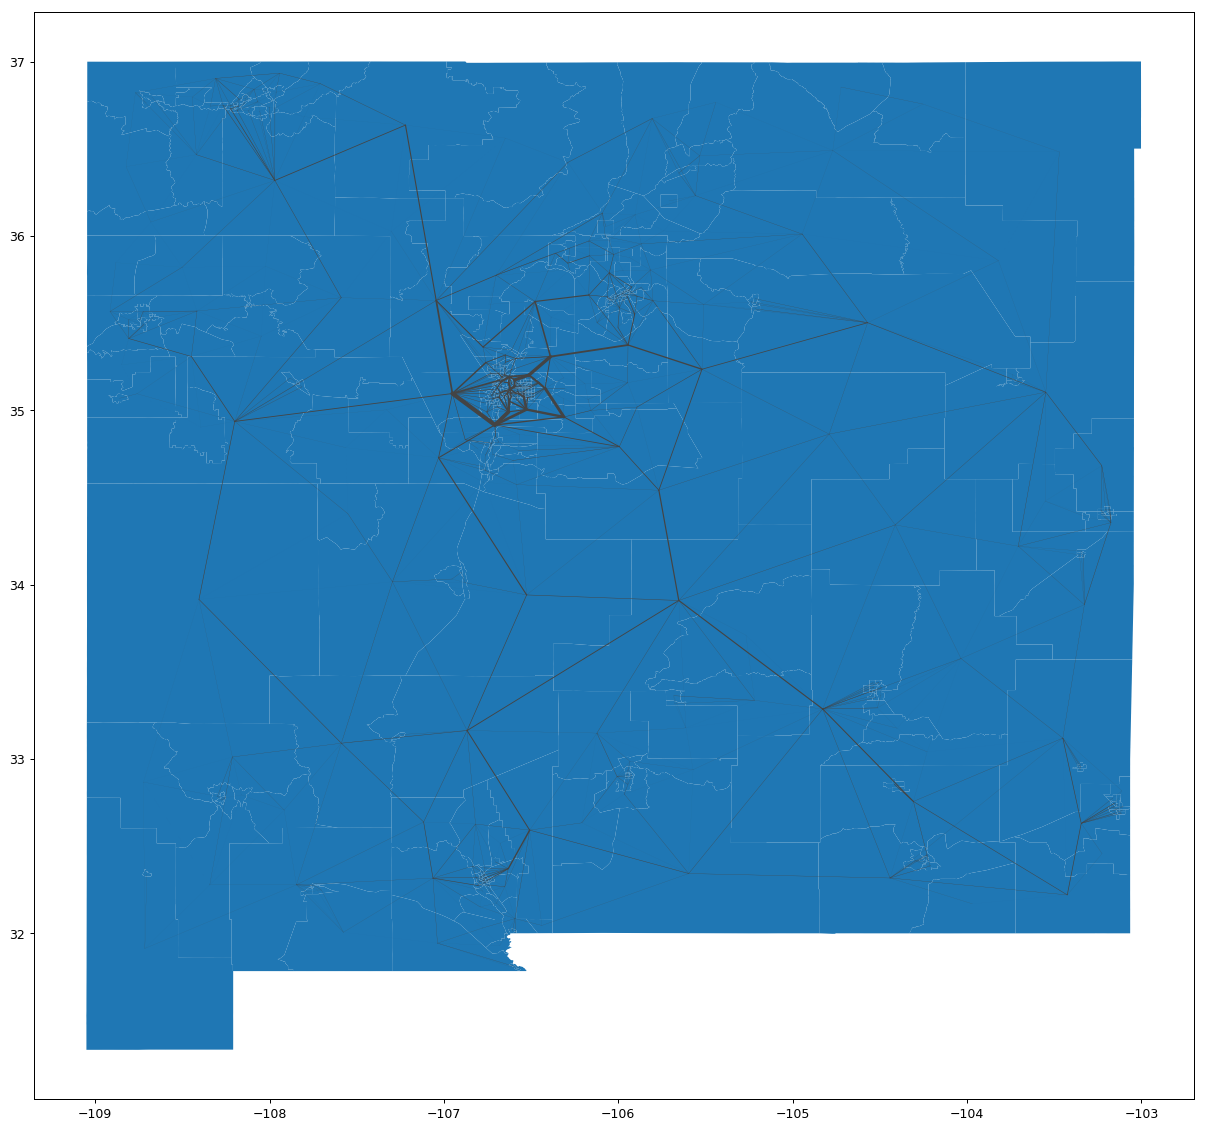

In [10]:
fig = plt.figure(1, figsize=(18, 16), dpi=90)
ax = fig.add_subplot(111)
zones.visualize_route_assignment(ax=ax)